In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import BinaryJaccardIndex, BinaryAccuracy

from dataset import DogDataset
from model import UNet
from evaluate_model import evaluate_model

# Hyper parameters

In [13]:
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 1e-4
NUM_OF_CLASSES = 1
TAKE_INDEXES_BELOW = 41

# Loading data set

In [26]:
dog_dataset_dir = "DatasetOxford"
transform_for_unet = Compose([
    Resize((512,512)),
    ToTensor(),
])

dog_dataset = DogDataset(dataset_dir=dog_dataset_dir, indexes_below=TAKE_INDEXES_BELOW, transform=transform_for_unet)
print("Length of dataset: ", len(dog_dataset))




Length of dataset:  992


# Dividing data into train, validation and test sets

In [27]:
train_data_length = math.ceil(0.7 * len(dog_dataset))
validation_data_length = math.ceil(0.15 * len(dog_dataset))
test_data_length = len(dog_dataset) - train_data_length - validation_data_length

train_data, valid_data, test_data = random_split(dog_dataset, [train_data_length, validation_data_length, test_data_length])

print("Test dataset length: ", len(test_data))
print("Validation dataset length: ", len(valid_data))
print("Train dataset length: ", len(train_data))
print("Sum = ", (len(test_data) + len(valid_data) + len(train_data)))

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

Test dataset length:  148
Validation dataset length:  149
Train dataset length:  695
Sum =  992


# Visualising data

Data batch shape: torch.Size([8, 3, 512, 512])
Labels batch shape: torch.Size([8, 1, 512, 512])
torch.Size([512, 512])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


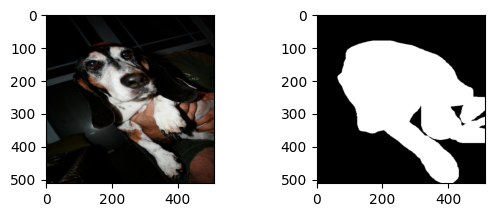

In [5]:
data_imges, label_imges = next(iter(train_dataloader))
print(f"Data batch shape: {data_imges.size()}")
print(f"Labels batch shape: {label_imges.size()}")

data_img = data_imges[0].permute(1, 2, 0).numpy()
label_img = label_imges[0].squeeze()

print(label_img.shape)
print(label_img)

figure = plt.figure()
ax1 = figure.add_subplot(2,2,1)
ax1.imshow(data_img)
ax2 = figure.add_subplot(2,2,2)
ax2.imshow(label_img, cmap="gray")
plt.show()

In [6]:
# torch.set_printoptions(threshold=10000000)
# print(label_img)
# torch.set_printoptions(threshold=1000)
print(torch.max(label_img))

tensor(1.)


### Checking if the model looks correct

In [7]:
# input_image = torch.rand((1, 3, 512, 512))
# model_test = UNet(num_classes=NUM_OF_CLASSES)
# # Total parameters and trainable parameters.
# total_params = sum(p.numel() for p in model_test.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(
#     p.numel() for p in model_test.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")
# outputs = model_test(input_image)
# print(outputs.shape)

# Model with validation and adaptive learning rate

### Model initialization

In [6]:
model_w_valid = UNet(num_classes=NUM_OF_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_w_valid.to(device)

loss_fn_valid = nn.BCEWithLogitsLoss()
optimizer_valid = torch.optim.Adam(model_w_valid.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_valid, mode='min', factor=0.5, patience=3)

# Variable to track the best validation loss
best_val_loss = float('inf')
best_val_iou = 0
best_val_accuracy = 0

best_loss_model_path = "best_loss_model.pth"
best_iou_model_path = "best_iou_model.pth"
best_accuracy_model_path = "best_accuracy_model.pth"

iou_metric = BinaryJaccardIndex().to(device)
accuracy_metric = BinaryAccuracy().to(device)

### Training with validation

In [ ]:
for epoch in range(EPOCHS):
    model_w_valid.train()
    train_running_loss = 0
    print(f"Current EPOCH {epoch + 1}")

    # Training Loop
    for idx, data in enumerate(train_dataloader):
        img = data[0].float().to(device)
        mask = data[1].float().to(device)

        predicted_mask = model_w_valid(img)
        optimizer_valid.zero_grad()

        loss = loss_fn_valid(predicted_mask, mask)
        train_running_loss += loss.item()

        loss.backward()
        optimizer_valid.step()

    # Average training loss
    train_loss = train_running_loss / (idx + 1)
    print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")

    # Validation Loop
    model_w_valid.eval()
    val_running_loss = 0
    iou_metric.reset()
    accuracy_metric.reset()

    with torch.no_grad():
        for val_idx, val_data in enumerate(valid_dataloader):
            val_img = val_data[0].float().to(device)
            val_mask = val_data[1].float().to(device)

            val_predicted_mask = model_w_valid(val_img)
            val_loss = loss_fn_valid(val_predicted_mask, val_mask)
            val_running_loss += val_loss.item()

            iou_metric.update(val_predicted_mask, val_mask.int())
            # Commented as this was used to debug IOU calculations
            # print("IOU calculations")
            # print(iou_metric(val_predicted_mask, val_mask.int()))
            # print(iou_metric(val_mask, val_mask.int()))
            accuracy_metric.update(val_predicted_mask, val_mask.int())

    val_loss = val_running_loss / (val_idx + 1)
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")

    # Compute mean IoU and accuracy over all validation batches
    mean_iou = iou_metric.compute().item()
    mean_accuracy = accuracy_metric.compute().item()
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_w_valid.state_dict(), best_loss_model_path)
        print(f"New best model saved with validation loss: {val_loss:.4f}")

    if mean_iou > best_val_iou:
        best_val_iou = mean_iou
        torch.save(model_w_valid.state_dict(), best_iou_model_path)
        print(f"New best model saved with IoU: {mean_iou:.4f}")

    if mean_accuracy > best_val_accuracy:
        best_val_accuracy = mean_accuracy
        torch.save(model_w_valid.state_dict(), best_accuracy_model_path)
        print(f"New best model saved with accuracy: {mean_accuracy:.4f}")

    scheduler.step(val_loss)
    model_w_valid.train()

Current EPOCH 1
Train Loss EPOCH 1: 0.6832
IOU calculations
tensor(0., device='cuda:0')
tensor(0.9916, device='cuda:0')
IOU calculations
tensor(1.8537e-06, device='cuda:0')
tensor(0.9916, device='cuda:0')
IOU calculations
tensor(8.1432e-07, device='cuda:0')
tensor(0.9933, device='cuda:0')
IOU calculations
tensor(1.7079e-06, device='cuda:0')
tensor(0.9888, device='cuda:0')
IOU calculations
tensor(2.2563e-06, device='cuda:0')
tensor(0.9923, device='cuda:0')
IOU calculations
tensor(0., device='cuda:0')
tensor(0.9897, device='cuda:0')
IOU calculations
tensor(0., device='cuda:0')
tensor(0.9917, device='cuda:0')
IOU calculations
tensor(1.3194e-06, device='cuda:0')
tensor(0.9890, device='cuda:0')
IOU calculations
tensor(1.0866e-06, device='cuda:0')
tensor(0.9903, device='cuda:0')
IOU calculations
tensor(0., device='cuda:0')
tensor(0.9920, device='cuda:0')
IOU calculations
tensor(0., device='cuda:0')
tensor(0.9908, device='cuda:0')
IOU calculations
tensor(1.4812e-06, device='cuda:0')
tensor(0.

### Inference of a loaded best model with validation

C:\Users\MatG\AppData\Local\Temp\ipykernel_13796\1155656733.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_w_valid.load_state_dict(torch.load(best_loss_model_path

tensor([[[[0.2364, 0.1496, 0.1209,  ..., 0.0833, 0.1125, 0.2205],
          [0.1251, 0.0644, 0.0469,  ..., 0.0226, 0.0368, 0.1178],
          [0.1011, 0.0488, 0.0364,  ..., 0.0121, 0.0200, 0.0807],
          ...,
          [0.0468, 0.0137, 0.0074,  ..., 0.0034, 0.0064, 0.0413],
          [0.0725, 0.0242, 0.0135,  ..., 0.0066, 0.0120, 0.0634],
          [0.1697, 0.0878, 0.0584,  ..., 0.0380, 0.0597, 0.1658]]]],
       device='cuda:0')
MAX: 
1


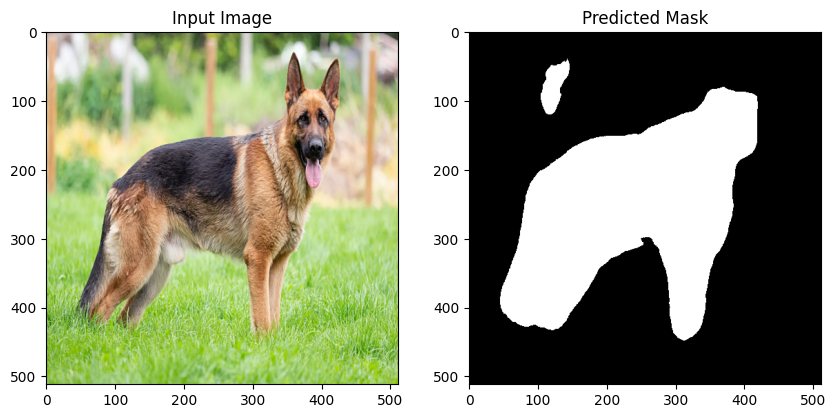

In [ ]:
# Loading model
model_w_valid.load_state_dict(torch.load(best_loss_model_path, map_location=device))
# Set the model in evaluation mode for inference
model_w_valid.eval()

# Define a transform for the test image
inference_transform = Compose([Resize((512, 512)), ToTensor()])

# Load and preprocess the test image
# test_image_path = "scottish_terrier_101.jpg"
test_image_path = "inference_img2.webp"
# test_image_path = "zdjecbezpsa.jfif"
# test_image_path = "pies.webp"
test_image = Image.open(test_image_path).convert("RGB")
test_image = test_image.resize([512,512])
input_tensor = inference_transform(test_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Run inference
with torch.no_grad():  # No gradient computation needed
    predicted_output = model_w_valid(input_tensor)
    predicted_output = torch.sigmoid(predicted_output)

print(predicted_output)
# Apply sigmoid and threshold to create a binary mask
binary_mask = predicted_output.squeeze().cpu().numpy()  # Apply sigmoid to get probabilities
binary_mask = (binary_mask > 0.7).astype(int)  # Threshold at at least 0.5 to create a binary mask
print("MAX: ")
print(np.max(binary_mask))

# Visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap="gray")
plt.title("Predicted Mask")
plt.show()

### Evaluation of a model with validation

In [28]:
mean_iou, mean_accuracy = evaluate_model(model_w_valid, test_dataloader, device, threshold=0.7)

Mean IoU: 0.7374
Mean Accuracy: 0.8769
